# Arithmetic Experiments

## Imports

In [1]:
from os.path import dirname, abspath
import sys, os
d = dirname(os.path.abspath(''))
sys.path.append(d)

from implicitdl import ImplicitModel, ImplicitModelLoRA, ImplicitFunctionInf, ImplicitFunctionTriu

import torch
from torch import nn
import torch.nn.functional as F
device = torch.device('cuda')
print('using ' + str(device))
torch.set_default_device(device)

import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# seed = 1234
# np.random.seed(seed)
# torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(seed)
    
%matplotlib inline

using cuda


/home/ubuntu/miniconda3/envs/sim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Generation

In [2]:
DIM = 5
SAMPLES = 10000

randrange = lambda dim: sorted(np.random.choice(range(dim+1), size=2, replace=False))

funcs = {
    'add': lambda a, b: a+b,
    'sub': lambda a, b: a-b,
    'mul': lambda a, b: 0.5*a*b,
    'div': lambda a, b: a/b,
    'custom_1': lambda a, b: a + torch.sin(b),
    'custom_2': lambda a, b: a**3 - 3*b**2 + a**2*b,
}

# n, m = randrange(DIM)
# p, q = randrange(DIM)
n, m = 0, DIM//2
p, q = DIM//2, DIM

def make_data(lower, upper, func):
    X = torch.tensor(np.random.uniform(lower, upper, size=(SAMPLES, DIM)), device=device, dtype=torch.float)
    a = X[:, n:m].sum(axis=-1).unsqueeze(-1)
    b = X[:, p:q].sum(axis=-1).unsqueeze(-1)
    y = func(a, b)
    return X, y

# def make_data(lower, upper, func):
#     X = torch.tensor(np.random.uniform(lower, upper, size=(SAMPLES, DIM)), device=device, dtype=torch.float)
#     y = torch.sum(X, -1)
#     return X, y.unsqueeze(-1)

## Training Code

In [3]:
def train(model, X, y, epochs, lr):
    [nn.init.kaiming_uniform_(p, mode='fan_in', nonlinearity='relu') for p in model.parameters()]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []
    
    model.train()
    for _ in range(epochs):
        pred = model(X)
        loss = F.mse_loss(pred, y)
        l1_lambda = 0.01
        l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
        loss = loss + l1_lambda * l1_norm
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        losses.append(loss.item())
        # it.set_postfix(lr=scheduler.get_last_lr()[0])
            
    return losses

## Model Generation
To override the default nonlinearity (ReLU), override the implicit function you wish to use, and replace the phi and dphi (gradient of nonlinearity) methods.

In [4]:
class CustomInf(ImplicitFunctionInf):
    """
    Change the default convergence parameters.
    """
    mitr = grad_mitr = 500
    tol = grad_tol = 1e-6

class ImplicitFunctionInfSiLU(CustomInf):
    """
    An implicit function that uses the SiLU nonlinearity.
    """
    # triu = False
    @staticmethod
    def phi(X):
        return X * torch.sigmoid(X)

    @staticmethod
    def dphi(X):
        grad = X.clone().detach()
        sigmoid = torch.sigmoid(grad)
        return sigmoid * (1 + grad * (1 - sigmoid))
    
class ImplicitFunctionTriuSiLU(ImplicitFunctionTriu):
    """
    An implicit function that uses the SiLU nonlinearity.
    """
    mitr = grad_mitr = 500
    tol = grad_tol = 1e-6
    # triu = True
    @staticmethod
    def phi(X):
        return X * torch.sigmoid(X)

    @staticmethod
    def dphi(X):
        grad = X.clone().detach()
        sigmoid = torch.sigmoid(grad)
        return sigmoid * (1 + grad * (1 - sigmoid))
    
def fuse_parameters(model):
    """Move model parameters to a contiguous tensor, and return that tensor."""
    n = sum(p.numel() for p in model.parameters())
    params = torch.zeros(n)
    i = 0
    for p in model.parameters():
        params_slice = params[i:i + p.numel()]
        params_slice.copy_(p.flatten())
        p.data = params_slice.view(p.shape)
        i += p.numel()
    return params

def compute_accuracy(y_pred, y_true):
    close = (torch.abs(y_pred - y_true)/torch.abs(y_true) < 1e-2).float()
    return close.mean()

In [5]:
input_size = DIM
lora_size = 5
hidden_size = 20
output_size = 1
more_state = 2
make_imp_relu = lambda: ImplicitModel(hidden_size, input_size, output_size, f=CustomInf, no_D=False)
make_imp_triu_l = lambda: ImplicitModel(hidden_size+more_state, input_size, output_size, f=ImplicitFunctionTriu, no_D=False)
make_imp_triu_s = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionTriu, no_D=False)
make_imp_silu = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionInfSiLU, no_D=False)
make_imp_triu_silu_l = lambda: ImplicitModel(hidden_size+more_state, input_size, output_size, f=ImplicitFunctionTriuSiLU, no_D=False)
make_imp_triu_silu_s = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionTriuSiLU, no_D=False)
make_imp_lora = lambda: ImplicitModelLoRA(lora_size, hidden_size, input_size, output_size, f=CustomInf, no_D=False)

In [6]:
def make_mlp(act):
    return nn.Sequential(
        nn.Linear(DIM, hidden_size, bias=False),
        act(),
        nn.Linear(hidden_size, hidden_size, bias=False),
        act(),
        # nn.Linear(hidden_size, hidden_size, bias=False),
        # act(),
        nn.Linear(hidden_size, 1, bias=False),
    )

## Full Pipeline

In [7]:
EPOCHS = 150
LR = 0.08

In [8]:
# task = "add"
# task = "sub"
# task = "mul"
task = "custom_1"
# task = "custom_2"
X, y = make_data(-1, 1, funcs[task])

models = {
    # 'ImplicitTriu_L': make_imp_triu_l().to(device),
    # 'ImplicitTriu_S': make_imp_triu_s().to(device),
    # 'ImplicitTriuSiLU_L': make_imp_triu_silu_l().to(device),
    # 'ImplicitTriuSiLU_S': make_imp_triu_silu_s().to(device),
    'Implicit': make_imp_relu().to(device),    
    # 'ImplicitSiLU': make_imp_silu().to(device),
    'ImplicitLoRA': make_imp_lora().to(device),
    'MLP': make_mlp(nn.SiLU).to(device),
    # 'MLPSiLU': make_mlp(nn.SiLU).to(device)
}

print('Model Sizes:')
for name, model in models.items():
    if name == 'ImplicitTriuSiLU_L' or name == "ImplicitTriuSiLU_S":
    # if model.triu == True:
        print(name)
        size = model.A.detach().cpu().numpy().size
        non_learnable = int(size/2 - model.A.shape[0]/2)
        print(f'{name}: {sum(p.numel() for p in model.parameters()) - non_learnable} parameters')
    else:
        print(f'{name}: {sum(p.numel() for p in model.parameters())} parameters')
    # [nn.init.constant_(p, -0.01) for p in model.parameters()]


Model Sizes:
Implicit: 525 parameters
ImplicitLoRA: 325 parameters
MLP: 520 parameters


In [9]:
num_exps = 10
factors = np.linspace(1, 10, num=10)
losses = {}

X_tests, y_tests = [], []
for factor in factors:
    X_test, y_test = make_data(-factor, factor, funcs[task])
    X_tests.append(X_test)
    y_tests.append(y_test)

losses = {name: [] for name in models}
extraps = {name: [[] for factor in factors] for name in models}
extraps_acc = {name: [[] for factor in factors] for name in models}
for name, model in models.items():
    print(name)
    for i in range(num_exps):
        losses[name].append(train(model, X, y, EPOCHS, LR))
        for k in range(len(factors)):
            with torch.no_grad():
                extraps[name][k].append(F.mse_loss(model(X_tests[k]), y_tests[k]).item())
                extraps_acc[name][k].append(compute_accuracy(model(X_tests[k]), y_tests[k]).item())

Implicit


RuntimeError: linalg.matrix_norm: Order inf not supported.

In [ ]:
mean_losses = {name: [] for name in models}
std_losses = {name: [] for name in models}
mean_extraps = {name: [] for name in models}
std_extraps = {name: [] for name in models}
mean_extraps_acc = {name: [] for name in models}
std_extraps_acc = {name: [] for name in models}
for name, model in models.items():
    mean_losses[name] = np.mean(losses[name], 0)
    std_losses[name] = np.std(losses[name], 0)
    mean_extraps[name] = np.mean(extraps[name], 1)
    std_extraps[name] = np.std(extraps[name], 1)
    mean_extraps_acc[name] = np.mean(extraps_acc[name], 1)
    std_extraps_acc[name] = np.std(extraps_acc[name], 1)
    print(name)
    print(" train(lasso):", mean_losses[name][-1])
    print(" test(mse):", mean_extraps[name][0])
    print(" acc:", mean_extraps_acc[name][0])
    params = fuse_parameters(model)
    print(" nonzeros:", torch.count_nonzero(params).item())
    print("\n")
my_task = (task, mean_losses, std_losses, mean_extraps)

Implicit
 train(lasso): 0.06159770116209984
 test(mse): 0.021709324233233927
 acc: 0.06820999756455422
 nonzeros: 359


ImplicitLoRA
 train(lasso): 0.27637222707271575
 test(mse): 0.027189618721604348
 acc: 0.05771999843418598
 nonzeros: 325


MLP
 train(lasso): 0.06900118365883827
 test(mse): 0.003478641202673316
 acc: 0.1576799973845482
 nonzeros: 520




## Plot Results

In [ ]:
styles = ['--', '-.', '-', ':', '-', '--', '-.', ':']

/tmp/ipykernel_6908/3066821917.py:8: RuntimeWarning: invalid value encountered in log10
  ax.fill_between(range(len(model_loss)), np.log10(model_loss - model_loss_std), np.log10(model_loss + model_loss_std), alpha=0.2)


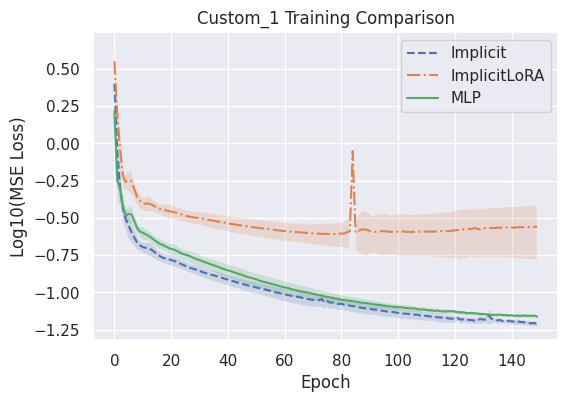

In [ ]:
my_task = (task, mean_losses, std_losses, mean_extraps, std_extraps)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.rcParams['axes.grid'] = True
for ax, (name, mean_loss, std_loss, _, _) in zip([axes], [my_task]):
    
    for style, (model_name, model_loss), (_, model_loss_std)  in zip(styles, mean_loss.items(), std_loss.items()):
        ax.plot(range(len(model_loss)), np.log10(model_loss), label=model_name, ls=style)
        ax.fill_between(range(len(model_loss)), np.log10(model_loss - model_loss_std), np.log10(model_loss + model_loss_std), alpha=0.2)
        # ax.plot(range(len(model_loss)), (model_loss), label=model_name, ls=style)
        # ax.fill_between(range(len(model_loss)), (model_loss - model_loss_std),(model_loss + model_loss_std), alpha=0.2)    
    # ax.set_ylim(-5, 2)
    ax.set_title(f'{name.title()} Training Comparison')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log10(MSE Loss)')
    ax.legend()
    
plt.show()

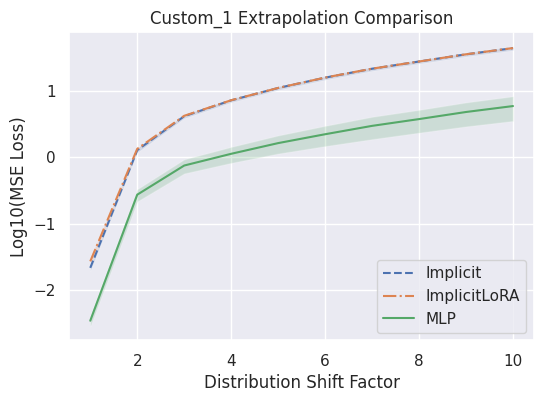

In [ ]:
my_task = (task, mean_losses, std_losses, mean_extraps, std_extraps)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
for ax, (name, _, _, mean_extrap, std_extrap) in zip([axes], [my_task]):
    
    for style, (model_name, model_extrap), (_, model_extrap_std) in zip(styles, mean_extrap.items(), std_extrap.items()):
        ax.plot(factors, np.log10(model_extrap), label=model_name, ls=style)
        ax.fill_between(factors, np.log10(model_extrap - model_extrap_std), np.log10(model_extrap + model_extrap_std), alpha=0.2)
        # ax.plot(factors, (model_extrap), label=model_name, ls=style)
        # ax.fill_between(factors, (model_extrap - model_extrap_std), (model_extrap + model_extrap_std), alpha=0.2)
    
    # ax.set_ylim(-5, 10)
    ax.set_title(f'{name.title()} Extrapolation Comparison')
    ax.set_xlabel('Distribution Shift Factor')
    ax.set_ylabel('Log10(MSE Loss)')
    ax.legend()
    
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import scipy.sparse as sp

model_name = 'ImplicitSiLU'
# model_name = 'ImplicitTriuSiLU_L'
# model_name = 'ImplicitTriuSiLU_S'
# model_name = 'ImplicitLoRA'
vis_model = models[model_name].to('cpu')
plt.rcParams['axes.grid'] = False
plt.figure(figsize=(6, 4))
matrix = np.abs(vis_model.A.detach().numpy())
# matrix = np.abs((vis_model.A1 @ vis_model.A2).detach().numpy())
print(matrix)
non_zero_weights = np.isclose(matrix, 0, 1e-5) == False
im = plt.imshow(non_zero_weights, cmap='Greys', aspect='equal')
plt.title(f'{model_name}: n_params = {matrix.size}, n_nonzeros = {np.count_nonzero(non_zero_weights)}\n')
plt.xlabel('Input Neurons')
plt.ylabel('Output Neurons')

cbar = plt.colorbar(im)
cbar.set_label('Weight Magnitude')

plt.tight_layout()
plt.show()

KeyError: 'ImplicitSiLU'

how to evaluate sparsity:
- absolute number of nonzeros
- percentage of nonzeros

robustness
- enable some random lower triangular elements, increase 10% number of parameters, add L1 norm (encourage sparsity, reduce 10% number of nonzeros) and hope for better performance and robustness